## Rotary Positional Embeddings

https://nn.labml.ai/transformers/rope/index.html

https://blog.eleuther.ai/rotary-embeddings/

### Transfromers Again

In [1]:
import torch
from torch import nn

In [2]:
class Config:    
    vocab_size = 4026
    dim = 552
    n_heads = 12
    head_size = dim // n_heads
    n_layers = 12
    n_kv_heads = 3
    seq_len = 1024
    multiple_of = 256
    
config = Config()

In [3]:

class RoPE(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.cos_mthetas = None
        self.sin_mthetas = None
        self.__set_thetas()
        
    def __set_thetas(self):
        """This sets the parameters of the rope as per the formula
        Θ = {θi = 10000−2(i−1)/d, i ∈ [1, 2, ..., d/2]}
        """
        assert self.config.head_size % 2 == 0, f"Head size:{self.config.head_size} shouls be even number"
        self.d = self.config.head_size
        self.m = self.config.seq_len
        
        i_s = torch.tensor(range(1,self.d//2+1))
        i_s = torch.cat([i_s,i_s], axis=-1)
        m_s = torch.tensor(range(self.m)).unsqueeze(axis=-1)
        
        thetas = 10000 ** (-2*(i_s-1)/self.d)
        self.cos_mthetas = torch.cos(m_s * thetas).to("cuda")
        self.sin_mthetas = torch.sin(m_s * thetas).to("cuda")
        
    def forward(self, x):
        """ assumes x in the format of """
        d  = x.shape[-1]
        print(f"shapes in RoPE in oredr x, : {x.shape, self.cos_mthetas.shape},d:{d}")
        assert d == self.d
        
        x = self.cos_mthetas * x + self.sin_mthetas * torch.cat([-1 * x[:,:,:,self.d//2:],x[:,:,:,:self.d//2]], axis=-1)
        return x
        
    
    

In [14]:
d = config.head_size
m = config.seq_len

i_s = torch.tensor(range(1,d//2+1))
i_s = torch.cat([i_s,i_s], axis=-1)
m_s = torch.tensor(range(m)).unsqueeze(axis=-1)

thetas = 10000 ** (-2*(i_s-1)/d)
cos_mthetas = torch.cos(m_s * thetas)
sin_mthetas = torch.sin(m_s * thetas)

In [15]:
m_s.shape, thetas.shape, cos_mthetas.shape, sin_mthetas.shape

(torch.Size([1024, 1]),
 torch.Size([46]),
 torch.Size([1024, 46]),
 torch.Size([1024, 46]))

In [21]:
x = torch.rand(size=(4, 12, 16, d))
d  = x.shape[-1]
t = x.shape[-2]
x = cos_mthetas[:t,:] * x + sin_mthetas[:t,:] * torch.cat([-1 * x[:,:,:,d//2:],x[:,:,:,:d//2]], axis=-1)

In [22]:
x.shape

torch.Size([4, 12, 16, 46])

In [4]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_rep = self.config.n_heads // self.config.n_kv_heads
        self.query = nn.Linear(self.config.dim, self.config.n_heads * self.config.head_size, bias=False)
        self.key = nn.Linear(self.config.dim, self.config.n_kv_heads * self.config.head_size, bias=False)
        self.value = nn.Linear(self.config.dim, self.config.n_kv_heads * self.config.head_size, bias=False)
        self.rope = RoPE(self.config)
        self.proj = nn.Linear(self.config.n_heads * self.config.head_size, self.config.n_heads * self.config.head_size, bias=False)
        
    def forward(self, x, y=None):
        b,t,d = x.shape
        q = self.query(x).view(b,t,self.config.n_heads,self.config.head_size)
        k = self.key(x).view(b,t,self.config.n_kv_heads,self.config.head_size)
        v = self.value(x).view(b,t,self.config.n_kv_heads,self.config.head_size)
        print(f"Shapes of Q, K, V: {q.shape, k.shape, v.shape}")
        
        ## Add rotary embeddings        
        q = self.rope(q.permute(0,2,1,3)).permute(0,2,1,3)
        k = self.rope(k.permute(0,2,1,3)).permute(0,2,1,3)
        
        ##GQA 
        k = repeat_kv(k,self.n_rep)
        v = repeat_kv(v,self.n_rep)
        print(f"Shapes of Q, K, V: {q.shape, k.shape, v.shape}")
        # make heads into a batch dimension
        q = q.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        ## Flash attention
        x = nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        
         # restore time as batch dimension and concat heads
        x = x.transpose(1, 2).contiguous().view(b, t, -1)

        # final projection into the residual stream
        x = self.proj(x)
        
        return x
        

        
        
        
    

In [5]:
class FeedForwordNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config        
        hidden_units = int(self.config.dim * 4 * 2/3) ##
        hidden_units = int(hidden_units - (hidden_units % self.config.multiple_of) + self.config.multiple_of)
        
        self.w = nn.Linear(self.config.dim, hidden_units)
        self.v = nn.Linear(self.config.dim, hidden_units)
        self.w2 = nn.Linear(hidden_units, self.config.dim)
        self.silu = nn.SiLU()
        
    def forward(self, x):
        out = self.w2(self.silu(self.w(x)) * self.v(x))
        return out

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.eps = 1e-5
        self.dim = config.dim
        self.weight = nn.Parameter(torch.ones(self.dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [7]:
class AttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.mha = MultiHeadAttention(self.config)
        self.ffn = FeedForwordNetwork(self.config)
        self.anorm = RMSNorm(config)
        self.fnorm = RMSNorm(config)
        
    def forward(self,x):
        x = x + self.mha(self.anorm(x))
        x = x + self.ffn(self.fnorm(x))
        return x
        

In [8]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding_layer = nn.Embedding(self.config.vocab_size, self.config.dim)
        self.layers = nn.Sequential(*[AttentionLayer(self.config) for _ in range(self.config.n_layers)])
        self.hnorm = RMSNorm(config)
        self.clf_head = nn.Linear(self.config.dim, self.config.vocab_size)
    
    def forward(self, x, y=None):
        x = self.embedding_layer(x)
        x = self.layers(x)
        x = self.hnorm(x)
        x = self.clf_head(x)
        return x
        
            

In [211]:
multiple_of = 256
hidden_dim = 4 * 512
print(hidden_dim)
hidden_dim = int(2 * hidden_dim / 3)
print(hidden_dim)
hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
print(hidden_dim)

2048
1365
1536


## Testing 

In [178]:
### Attention

In [239]:
516 / 12

43.0

In [253]:
46 * 12

552

In [254]:
552 / 12

46.0

In [259]:
attention = Attention(config)

In [260]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0
out = attention(x)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))


In [261]:
x.shape, out.shape

(torch.Size([16, 1024, 552]), torch.Size([16, 1024, 552]))

In [266]:
ff = FeedForword(config)
ffout = ff(out)

In [267]:
x.shape, out.shape, ffout.shape

(torch.Size([16, 1024, 552]),
 torch.Size([16, 1024, 552]),
 torch.Size([16, 1024, 552]))

In [197]:
x = x.view(16, config.seq_len, config.n_heads, config.head_size)
x.shape

torch.Size([16, 1024, 8, 64])

## AttentionLayer Test

In [283]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0
layer = AttentionLayer(config)
out = layer(x)
print(x.shape, out.shape)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
torch.Size([16, 1024, 552]) torch.Size([16, 1024, 552])


### Model Test

In [9]:
x = torch.ones(size=(16, config.seq_len), dtype=torch.int32).to("cuda")
model = Model(config).to("cuda")
out = model(x)
print(x.shape, out.shape)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), to

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 5.16 GiB is allocated by PyTorch, and 131.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n#######Total parameter of the model: {total_params * 1e-6}")


#######Total parameter of the model: 44.17053


In [199]:
xq = torch.rand(size=(16, config.seq_len, config.n_heads, config.head_size))
xq_r, xq_i = xq.float().reshape(xq.shape[:-1] + (-1, 2)).unbind(-1)

In [201]:
xq.shape[:-1] + (-1, 2)

torch.Size([16, 1024, 8, -1, 2])

In [202]:
xq.float().reshape(xq.shape[:-1] + (-1, 2)).shape

torch.Size([16, 1024, 8, 32, 2])

In [167]:
rope = RoPE(config)

In [168]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0

In [169]:
x.shape, x.view(16, config.seq_len, config.n_heads, config.head_size).shape

(torch.Size([16, 1024, 512]), torch.Size([16, 1024, 8, 64]))

In [170]:
x = x.view(16, config.seq_len, config.n_heads, config.head_size)

In [171]:
x = x.permute(0, 2, 1, 3)

In [172]:
x.shape

torch.Size([16, 8, 1024, 64])

In [173]:
x_rope = rope(x)

In [174]:
x.shape, x_rope.shape

(torch.Size([16, 8, 1024, 64]), torch.Size([16, 8, 1024, 64]))

In [73]:
x[0,0,:], x_rope[0,0,:]

(tensor([1., 1.]), tensor([1., 1.]))

In [75]:
x_rope[0,:,:].shape

torch.Size([1024, 2])

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

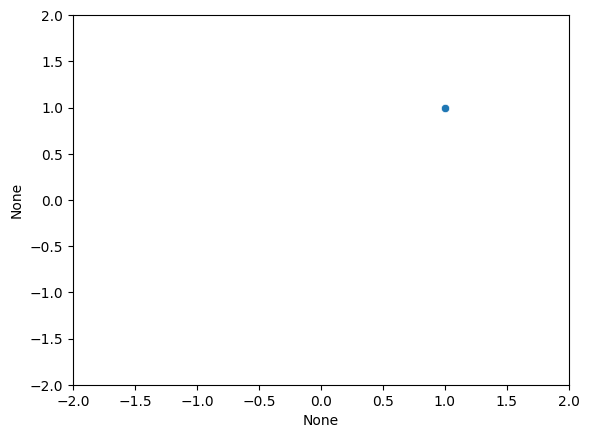

In [95]:
sns.scatterplot(x=x_rope[0,:1,0], y=x_rope[0,:1,1])
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()

In [97]:
x_rope[0,:,:].shape

torch.Size([1024, 2])

In [139]:
data = [[(0.0, 0.0, i),tuple(point +[i,])] for i,point in enumerate(x_rope[0,:,:].numpy().tolist())]

In [140]:
data = [row for sub in data for row in sub]
data[:5]

[(0.0, 0.0, 0),
 (1.0, 1.0, 0),
 (0.0, 0.0, 1),
 (-0.30116862058639526, 1.3817732334136963, 1),
 (0.0, 0.0, 2)]

In [141]:
df = pd.DataFrame(data=data, columns=["x1","x2","t"])
df.head()

,x1,x2,t
0,0.000000,0.000000,0
1,1.000000,1.000000,0
2,0.000000,0.000000,1
3,-0.301169,1.381773,1
4,0.000000,0.000000,2


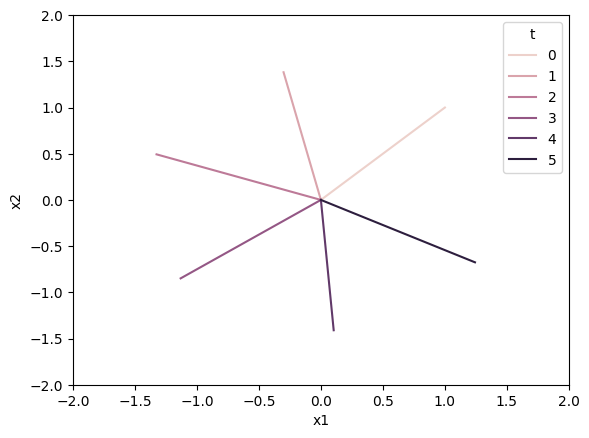

In [142]:
sns.lineplot(x="x1", y="x2",hue="t",data=df)
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()

In [108]:
tuple( [0.31338733434677124, -1.3790533542633057])

(0.31338733434677124, -1.3790533542633057)

In [99]:
import pandas as pd
pd.DataFrame(x_rope[0,:,:], columns=['x1','x2'])

,x1,x2
0,1.000000,1.000000
1,-0.301169,1.381773
2,-1.325444,0.493151
3,-1.131112,-0.848872
4,0.103159,-1.410446
...,...,...
1019,-0.469731,1.333924
1020,-1.376255,0.325457
1021,-1.017456,-0.982233
1022,0.276787,-1.386863


In [53]:
import torch
from torch import nn

In [54]:
l = nn.Linear(2,1)

In [63]:
x = torch.rand(5, 2)
x.shape

torch.Size([5, 2])

In [64]:
z = l(x)

In [65]:
z.sum().backward()

In [43]:
for param  in l.named_parameters():
    print(param)

('weight', Parameter containing:
tensor([[ 0.6814, -0.5939]], requires_grad=True))
('bias', Parameter containing:
tensor([-0.5288], requires_grad=True))


In [66]:
l.weight.grad

tensor([[7.5985, 6.5285]])

In [88]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = nn.Linear(10, 15)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(15, 5)

    def forward(self, x):
        return self.net2(self.relu(self.net1(x)))

In [89]:
model = ToyModel()

In [85]:
model.net1.weight[0,:2]

tensor([-0.0299,  0.1744], grad_fn=<SliceBackward0>)

In [91]:
x = torch.rand(32, 10)
y = model(x)
y.sum().backward()

In [95]:
model.net1.weight.grad.shape, model.net1.weight.shape

(torch.Size([15, 10]), torch.Size([15, 10]))

In [96]:
model.net1.weight.grad[0,:2]

tensor([-1.9570, -2.0191])

In [98]:
2 % 2

0

In [80]:
## configuration settings
class Config:
    
    vocab_size = 4096
    dim = 552
    n_heads = 12
    head_size = dim // n_heads
    n_layers = 12
    n_kv_heads = 3
    seq_len = 1024
    multiple_of = 256                
    batch_size = 16 
    global_batch_size = 100000 # number of tokens per update
    grad_accumulation_steps = int(global_batch_size/(seq_len * batch_size))
    learning_rate=5e-4
    total_params = 0
    tokenizer_path = "saved_artifacts/tokenizers"
    n_train_examples = -1
    n_val_examples = -1

config = Config()

In [82]:
Config.vocab_size

4096

In [10]:
from tinystories_dataset import TinyStories
dataste = TinyStories(config)

C:\Users\chaitanyamanem\anaconda3\envs\venv_clear_text\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Map (num_proc=4):   0%|          | 0/2119719 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/21990 [00:00<?, ? examples/s]

In [11]:
train_dataloder = dataste.getTrainDataLoader(ddp=False)

In [7]:
for batch in train_dataloder:
    print(batch["inputs"].shape)
    break

torch.Size([16, 1024])


In [16]:
print(f"Iters now: {len(train_dataloder)}")
print(f"Iters earlier: { 4 * len(train_dataloder)}")

Iters now: 30254
Iters earlier: 121016


In [22]:
int(150_000/(1024 * 16 * 2))

4

In [18]:
3  * 1024 * 16 * 2

98304

In [23]:
1024 * 16 * 2 * 4

131072

In [25]:
##
import logging
import time

start_time = time.time()
duration_secs = time.sleep(10)

print("--- %s seconds ---" % (time.time() - start_time))

--- 10.010102272033691 seconds ---


In [50]:
duration_secs = 3690
duration_secs // (60*60), duration_secs // 60, duration_secs

(1, 61, 3690)

In [51]:
120 * 60

7200

In [52]:
duration_secs // (60*60), (duration_secs % (60*60)) // 60, (duration_secs % (60*60)) % 60

(1, 1, 30)

In [47]:
61 * 60 + 31

3691

In [66]:
import logging
from datetime import datetime
import os
file_name = os.path.join("saved_artifacts","logs",datetime.now().strftime('log_%Y_%m_%d_%H_%M_%S.log'))
logging.basicConfig(level=logging.DEBUG, filename=file_name, filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.info('Execution started at ')

In [64]:
time.time()

AttributeError: 'float' object has no attribute 'strftime'

In [63]:
datetime.now().strftime('log_%Y_%m_%d_%H_%M_%S.log')



'log_2024_02_10_10_44_39.log'

In [69]:
start_time = datetime.now()
time.sleep(5)
print(datetime.now()-start_time)


0:00:05.010611


In [ ]:
100 - 1.13

In [83]:
30254 / 2

15127.0

In [84]:
60 * 1.13

67.8

In [ ]:
1 step 
68/100

In [85]:
15127 * 0.68

10286.36

In [87]:
10286.36 / 60

171.43933333333334

In [88]:
1024 * 16 * 2

3276800000

In [89]:
15127 * 4

60508

In [90]:
400_000 * 4 * 1024 = ? * 16 * 1024 * 2

1638400000

In [91]:
1638400000 / (16 * 1024 * 2)

50000.0

In [92]:
1.208 - 0.08

1.128

In [159]:
import torch
import numpy as np

vectors = np.array([
    [1,0,0],
    [1,3.0,4.0],
    
    [2,0,0],
    [2,4.0,3.0],
    
    [3,0,0],
    [3,10.0,5.0],
    
    [4,0,0],
    [4,10.0,0.5],     
    

    
])

#similarity
vector1 = vectors[1,:]
for i in range(3,vectors.shape[0]):
    if (i+1)%2 == 0:
        vector2 = vectors[i,:]
        print(f"dot product:{(torch.tensor(vector1).unsqueeze(0) @ torch.tensor(vector2).unsqueeze(0).transpose(-2,-1)).item()}")
        


dot product:26.0
dot product:53.0
dot product:36.0


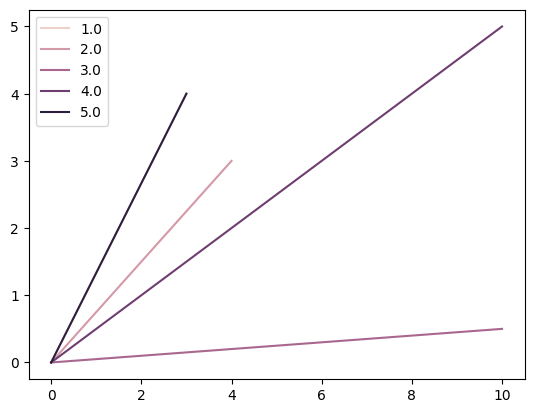

In [157]:
# importing package 
import matplotlib.pyplot as plt 
import seaborn as sns

# plot lines 
sns.lineplot(x=vectors[:,1], y=vectors[:,2], hue=vectors[:,0]) 
plt.legend() 
plt.show()

tensor([[16.]])

In [116]:
vector1, vector2

(tensor([[0.0667, 0.6802]]), tensor([[0.5924, 0.9558]]))

In [113]:
vector1 @ torch.transpose(vector1,0,1)

tensor([[1.2315]])

(tensor([[0.3271, 0.8240]]), tensor([[0.6256, 0.8163]]))

In [128]:
torch.cosine_similarity(vector1,vector1)

tensor([1.0000])

In [131]:
import numpy as np
vector1 @ torch.transpose(vector1,0,1)

tensor([[32.]])

2

In [29]:
import math

warmup_iters = 2000
max_iters = 100_000
lr_decay_iters = max_iters
learning_rate = 7e-4
min_lr = learning_rate / 10


def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

In [30]:
lrs = [get_lr(it) for it in range(max_iters)]

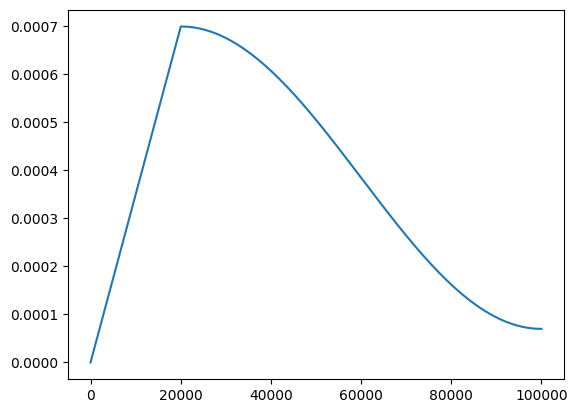

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=list(range(len(lrs))), y=lrs)
plt.show()

In [28]:
lrs[:4]

[3.5e-07, 7e-07, 1.05e-06, 1.4e-06]

In [18]:
5e-4 / 10

5e-05

In [33]:
import numpy as np
np.array([4,3]) @ np.array([5,1])

23

In [41]:
23/4

5.75

In [34]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [35]:
angle_between(np.array([4,3]), np.array([5,1]))

0.4461055489434035

In [62]:
import math
math.sqrt((5 ** 2 + 1 ** 2)), math.sqrt((4.5 ** 2 + 2.5 ** 2))

(5.0990195135927845, 5.1478150704935)

In [63]:
np.array([4,3]) @ np.array([5,1])

23

In [64]:
np.array([4,3]) @ np.array([2.5,4.5])

23.5

In [47]:
((23/25.495097567963924) * 5) ** 2

20.346153846153847

In [49]:
20.346/3

6.782

In [69]:
math.sqrt(2.4**2 + 1.8**2), math.sqrt(2.2**2 + 2.2 ** 2)

(3.0, 3.111269837220809)

In [77]:
math.sqrt(-0.217**2 + 2.992**2), math.sqrt((-2.915)**2 + 1.084 ** 2)

(2.9841204734393685, 3.110029099542318)

3.110029099542318

In [28]:
import math

1/4096

0.000244140625

In [29]:
math.exp(0.000244140625)

1.0002441704297478

In [31]:
(1024 * 16 * 30000) / 1_000_000

491.52

In [32]:
(1024 * 16 * 30000) / 1_000_000_000

0.49152

In [33]:
2.5 * 16 * 1024

40960.0

## Inference Test

##### Batch Generate

In [6]:
class Config:
    def __init__(self, world_size):
        self.vocab_size = 4096
        self.dim = 768
        self.n_heads = 8
        self.head_size = self.dim // self.n_heads
        self.n_layers = 8
        self.n_kv_heads = 8
        self.seq_len = 1024
        self.multiple_of = 256                
        self.batch_size = 64 
        self.global_batch_size = 150_000 # number of tokens per update
        self.world_size = world_size
        self.grad_accumulation_steps = int(self.global_batch_size/(self.seq_len * self.batch_size * self.world_size))
        self.grad_clip = 1.0
        self.learning_rate=1e-4
        self.min_lr = self.learning_rate / 10
        self.warmup_steps = 1000
        self.total_params = 0
        self.tokenizer_path = "saved_artifacts/tokenizers"
        self.saved_checkpoint_path = "saved_artifacts/models/model240221"
        self.rank = 0
        
config = Config(1)

In [7]:
from model import Model
import torch
import sentencepiece as spm
import tqdm
from automodel import AutoModel


tokenizer = spm.SentencePieceProcessor(model_file='saved_artifacts/tokenizers/tok_4096.model')    
model = Model(config)
model = AutoModel(model, config, device='cuda')


In [15]:
prompts = [
    "Hello",
    "Once there was a girl named Lilly",
    "Rowdy baby"
]
tokenized_prompts = []
max_seq_len = 0
for prompt in prompts:
    tokenized_prompt = tokenizer.tokenize(prompt, add_bos=True, add_eos=True)
    max_seq_len = max(len(tokenized_prompt) ,max_seq_len)
    tokenized_prompts.append(tokenized_prompt)

tokenized_prompts = [tokenized_prompt + [tokenizer.eos_id()]*(max_seq_len-len(tokenized_prompt))for tokenized_prompt in tokenized_prompts]
    
x = torch.tensor(tokenized_prompts, dtype=torch.long).to("cuda")

generation_config = {
    'padding_token': tokenizer.eos_id(),
    'bos_id': tokenizer.bos_id(),
    'max_new_tokens': 500,
    'temperature': 0.1
}

prompts, generations = model.generate(x,generation_config)

In [16]:
prompts = tokenizer.decode(prompts)
generations = tokenizer.decode(generations)


In [23]:
result = [{'prompt': prompt, 'generation': generation} for prompt, generation in zip(prompts,generations)]
result

import csv


keys = result[0].keys()

with open('people.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(result)

In [18]:
generations

['Hello, little dog. I am a dog. I am a boy. I like to play with you. You are my friend. You are loyal. You are fun. You are fun. You are fun."\n\nThe boy and the dog run and play. They chase a ball and a stick. They laugh and bark. They are happy. They are friends.\n\nBut then, the boy and the dog see a big cat. The cat is black and white. The cat is mean. The cat hisses and scratches. The cat says, "This is my park. You are not my friends. You are not fun. You are mean. You are mean. You are not loyal. You are bad."\n\nThe boy and the dog are scared. They do not like the cat. They do not like the cat. They do not like the cat. They want to go away.\n\nBut then, they hear a voice. The voice is loud and angry. The voice says, "Hey, you! Leave the cat alone! He is my friend. He is my family. He is loyal. He is fun. He is fun. He is my friend."\n\nThe boy and the dog are surprised. They look at the cat. The cat is not mean. The cat is not bad. The cat is not mean. The cat is not loyal. T

In [2]:
from model import Model
import torch
import sentencepiece as spm
import tqdm
from automodel import AutoModel



model = Model(config)
model = AutoModel(model, "saved_artifacts/models/model240221", config)
checkpoint = torch.load("saved_artifacts/models/model240221/checkpoint.pt")
## load model state dict
model.load_state_dict(checkpoint['model'])
model = model.to("cuda")
model.eval()
## Tokenizer
tokenizer = spm.SentencePieceProcessor(model_file='saved_artifacts/tokenizers/tok_4096.model')        



def generate(x, max_new_tokens=500, temperature=0.0):

    idx = x
    t = 0
    #gen_loop = tqdm.tqdm(total=max_new_tokens, desc="gen_progress")
    while t <= max_new_tokens and int(idx[:,-1].item()) != int(tokenizer.bos_id()):
        prompt = idx[:,-config.seq_len:]
        pred = model(prompt)
        logits = pred[:,-1,:]

        if temperature == 0.0:
            # "sample" the single most likely index
            _, idx_next = torch.topk(logits, k=1, dim=-1)
        else:
            # pluck the logits at the final step and scale by desired temperature
            logits = logits / temperature

        #logits = top_k_top_p_filtering(logits, top_p=top_p, top_k=top_k)


        logits = torch.softmax(logits, axis=-1)
        next_idx = torch.multinomial(logits, num_samples=1)        
        idx = torch.cat([idx, next_idx], axis=1)
        t += 1
        #gen_loop.update(1)
    return idx
    generated_text = tokenizer.decode(idx.to("cpu").numpy().tolist())
    gen_loop.write("\n###############################")
    gen_loop.write(generated_text[0])
    gen_loop.write("\n###############################")

In [3]:
tokenizer.bos_id()

1

In [83]:
max_prompt_len = 50
prompt = "One day a little girl called Shiva "
prompt_tokens = tokenizer.encode([prompt], add_bos=True)[0]
padded_prompt_tokens = [tokenizer.bos_id()]*max_prompt_len
padded_prompt_tokens[-len(prompt_tokens[:max_prompt_len]):] = prompt_tokens[:max_prompt_len]
padded_prompt_tokens = torch.tensor([padded_prompt_tokens],dtype=torch.long).to("cuda")
idx = generate(padded_prompt_tokens, temperature=0.1)
idx = idx.squeeze(axis=0).tolist()
print(tokenizer.decode(idx))

One day a little girl called Shivaed a little girl named Lily and her mommy were playing in the park. Lily was very excited because she was going to the park with her mom.

When they arrived, Lily saw a big, red balloon. She was so excited and asked her mom, "Can I have it?"

Her mom said, "Yes, you can have it. But first, let's go to the store and get some food for dinner."

Lily was so happy. She ran to the store and saw a big, red balloon. She asked her mom, "Can I have it?"

Her mom said, "Yes, you can have it. But first, let's get some food for dinner."

So they went to the food aisle and Lily picked out some yummy food. She was so excited to eat it.

When they got home, Lily and her mom had a big dinner. They ate the red food and it was so delicious. Lily was so happy and said, "Thank you, Mommy!"


In [69]:
print(tokenizer.decode(reponse_ids)[1])

[[1, 422, 361]]

In [62]:
l = [1,2,3,4,5]
l[-5:]

[1, 2, 3, 4, 5]

In [45]:
prompts = ["One day","Siva and bear both are friends"]
reponse_ids = []
for prompt in prompts:
    x = torch.tensor(tokenizer.encode([prompt]), dtype=torch.long).to("cuda")
    idx = generate(x, temperature=0.1)
    reponse_ids.append(idx.squeeze(axis=0).tolist())
    


gen_progress:   0%|                                                                            | 0/500 [39:22<?, ?it/s]


In [50]:
print(tokenizer.decode(reponse_ids)[1])

Siva and bear both are friends. They like to play in the park. They have a ball, a bike and a kite. They have fun.

One day, they see a big dog in the park. The dog is brown and furry. It has a collar and a leash. The dog barks and runs to them.

"Hello, dog!" Anna says. She wants to pet the dog. She likes dogs.

"Be careful, Anna!" Ben says. He is afraid of dogs. He thinks the dog might bite. He holds Anna's hand.

The dog stops barking. It wags its tail. It wants to play. It sees the ball and the bike. It likes them. It runs to them.

"Wow, a dog!" Anna says. She is happy. She likes dogs. She pets the dog.

"Be careful, Anna!" Ben says. He is worried. He does not like dogs. He thinks dogs are mean. He pulls Anna's hand.

The dog does not understand. It thinks Anna and Ben are playing. It jumps and bites the ball. It makes a mess.

"Ow, ow, ow!" Anna and Ben say. They are sad. They are angry. They do not like the dog.

The dog's owner comes. He is a man. He has a hat and a coat. He se

In [44]:
print(tokenizer.decode(reponse_ids))

One day, they saw a big truck with a picture of a cone on it. The truck was selling cones.

"Look, Ben, cones!" Lily said. "Let's go and see them."

They ran to the truck and saw a man with a hat. He smiled and said, "Hello, kids. Do you want a cone?"

"Yes, please!" Ben and Lily said.

The man gave them each a cone with a scoop of ice cream on top. Lily chose chocolate and Ben chose vanilla.

"Thank you, mister!" they said.

"You're welcome, kids. Enjoy your cones," the man said.

Lily and Ben licked their cones happily. They liked the ice cream. It was cold and sweet and yummy.

But then, a big dog came running. It saw the cones and wanted to play. It barked and jumped and tried to catch the cones.

"Hey, stop!" Lily shouted. "That's our cones!"

"Go away, dog!" Ben yelled. "You're bad!"

The dog did not listen. It kept barking and jumping and trying to get the cones.

Lily and Ben were scared. They did not like the dog. They wanted to go away.

But then, a man came. He was the dog's

In [35]:
idx[0]

tensor([ 422,  361, 3968,  349, 1543,  261,  296, 1856, 2091,  780,  589,  285,
         390, 2831, 3960,  317,  331,  282,  462,  857, 1828,  640, 2123,  320,
         265,  538, 3946, 3960,   13,   13, 1993,  659, 3974, 3948, 1772,  436,
        3968,  411,  265,  296,  340,  780,  595,  393,  298,  690,  312,  268,
         261, 1663, 3960,  289,  896,  595, 2024, 1950,  430,  269, 2408,  267,
         719,  285,  841, 3968,  411,  349, 1568, 3974, 3948,  949,  268,  335,
         297,  436, 3960,  315,  936, 1341,  267, 1341, 3968,  411,  594,  341,
        1219, 2071,  267, 1194, 3960,   13,   13, 1786, 2831,  595, 1357,  595,
         302, 3951,  372,  595,  393,  298,  690,  312,  267,  619,  306,  285,
         398,  371,  561, 1690,  267, 3283, 3960,  315,  285, 1851,  268, 1663,
        3968,  411,  875, 2011, 1826,  574,  421, 1684,  856,  261, 1118,  690,
        3957,  351,  595, 3947, 1600, 3960,  315,  816,  362, 1509,  306, 3974,
        3954,  387,  772,  664, 1708,  8

In [108]:
a1 = torch.rand(size=(4,8))
row = torch.arange(0,4).unsqueeze(axis=-1)
col = torch.tensor([[0,2,2,4]]).permute(1,0)

In [109]:
a1

tensor([[0.4889, 0.3619, 0.2616, 0.3882, 0.1020, 0.4791, 0.0825, 0.2193],
        [0.6540, 0.8920, 0.8110, 0.4591, 0.1197, 0.1988, 0.8841, 0.2273],
        [0.9916, 0.4762, 0.6308, 0.6293, 0.4023, 0.5723, 0.6750, 0.9671],
        [0.4034, 0.6587, 0.9476, 0.7676, 0.5436, 0.4817, 0.8547, 0.2095]])

In [110]:
a1[row,col]

tensor([[0.4889],
        [0.8110],
        [0.6308],
        [0.5436]])

In [111]:
col

tensor([[0],
        [2],
        [2],
        [4]])

In [112]:
col + 1

tensor([[1],
        [3],
        [3],
        [5]])

In [117]:
tokenizer.eos_id()

2

In [21]:
##
prompts = [
    "Hello",
    "Once there was a girl named Lilly",
    "Rowdy baby"
]
tokenized_prompts = []
max_seq_len = 0
for prompt in prompts:
    tokenized_prompt = tokenizer.tokenize(prompt, add_bos=True, add_eos=True)
    max_seq_len = max(len(tokenized_prompt) ,max_seq_len)
    tokenized_prompts.append(tokenized_prompt)

tokenized_prompts = [tokenized_prompt + [tokenizer.eos_id()]*(max_seq_len-len(tokenized_prompt))for tokenized_prompt in tokenized_prompts]
    
x = torch.tensor(tokenized_prompts, dtype=torch.long).to("cuda")
c_indi = torch.argmax(torch.where(x == tokenizer.eos_id(),1,0), axis=-1).unsqueeze(axis=1)
r_indi = torch.arange(0,x.shape[0]).unsqueeze(axis=-1)    

In [22]:
x

tensor([[   1,  317, 1945,    2,    2,    2,    2,    2,    2],
        [   1,  432,  401,  285,  261,  447,  502, 3820,    2],
        [   1, 1044,  323,  749, 1450,    2,    2,    2,    2]],
       device='cuda:0')

### Batch Generate

In [ ]:
pred = model(x)
logits = pred[r_indi, c_indi, :]
logits = torch.softmax(logits, axis=-1)
next_idxs = torch.multinomial(logits.squeeze(axis=1), num_samples=1)


In [12]:
pred = model(x)
pred.shape

torch.Size([3, 9, 4096])

In [13]:
pred[r_indi, c_indi, :].shape

torch.Size([3, 1, 4096])

In [15]:
temperature = 0.1
pred = model(x)
logits = pred[r_indi, c_indi, :]

# pluck the logits at the final step and scale by desired temperature
logits = logits / temperature

#logits = top_k_top_p_filtering(logits, top_p=top_p, top_k=top_k)


logits = torch.softmax(logits, axis=-1)
next_idx = torch.multinomial(logits, num_samples=1)        
idx = torch.cat([idx, next_idx], axis=1)
t += 1

RuntimeError: prob_dist must be 1 or 2 dim

In [16]:
pred = model(x)
logits = pred[r_indi, c_indi, :]
logits = torch.softmax(logits, axis=-1)

In [17]:
logits.shape

torch.Size([3, 1, 4096])

In [18]:
next_idxs = torch.multinomial(logits.squeeze(axis=1), num_samples=1)

In [19]:
x[r_indi, c_indi] = next_idxs

In [20]:
x

tensor([[   1,  317, 1945,  281,    2,    2,    2,    2,    2],
        [   1,  432,  401,  285,  261,  447,  502, 3820, 3960],
        [   1, 1044,  323,  749, 1450, 3952,    2,    2,    2]],
       device='cuda:0')

In [ ]:
c_indi += 1

In [170]:
eos_id_index = torch.zeros(size=(x.shape[0],1)).to("cuda")
eos_id_index

tensor([[0.],
        [0.],
        [0.]], device='cuda:0')

In [172]:
eos_id_index[next_idxs == tokenizer.eos_id()] = 1

## Dataset for Inferencing

In [35]:
from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader, DistributedSampler
import sentencepiece as spm
import os

dataset = load_dataset("roneneldan/TinyStories")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]


In [36]:
tokenizer_model_path = os.path.join("saved_artifacts/tokenizers","tok_4096.model")
tokenizer = spm.SentencePieceProcessor(model_file=tokenizer_model_path)

In [37]:


def process_rows_func(examples, tokenizer):   
    from random import randint    
    idx = 0 
    p_len = 30
    inputs, targets = [],[]
    
    
    tokenized_examples = tokenizer.encode(examples["text"], add_bos=True)
    for example in tokenized_examples:        
        inputs.append(example[:p_len])
        targets.append(example)
        
    return {"inputs":inputs}

val_dataset = val_dataset.map(
                    process_rows_func,
                    fn_kwargs={"tokenizer":tokenizer},
                    batched=True,
                    num_proc=4,
                    remove_columns=val_dataset.column_names    
                )
val_dataset.set_format(type='torch', columns=val_dataset.column_names)             

    

Map (num_proc=4):   0%|          | 0/21990 [00:00<?, ? examples/s]

In [38]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True) 

torch.Size([32, 30])


In [57]:
from model import Model

class Config:
    def __init__(self):
        self.vocab_size = 4096
        self.dim = 768
        self.n_heads = 8
        self.head_size = self.dim // self.n_heads
        self.n_layers = 8
        self.n_kv_heads = 8
        self.seq_len = 1024
        self.multiple_of = 256                
        self.batch_size = 32 
        self.global_batch_size = 150_000 # number of tokens per update
        self.world_size = torch.cuda.device_count()
        self.grad_accumulation_steps = int(self.global_batch_size/(self.seq_len * self.batch_size * self.world_size))
        self.grad_clip = 1.0
        self.learning_rate=1e-3
        self.min_lr = self.learning_rate / 10
        self.warmup_steps = 1000
        self.total_params = 0
        self.tokenizer_path = "saved_artifacts/tokenizers"        
        self.rank = 0 
        
config = Config()

model = Model(config)
model = model.to(0)

In [58]:
for data in val_loader:
    x = data['inputs'].to(0)
    print(model(x))
    break


tensor([[[-0.1738,  1.0943, -0.2407,  ..., -0.2396, -0.7592, -0.0543],
         [ 0.3763, -0.0708, -0.0694,  ...,  0.4578, -0.8039, -0.3586],
         [-0.1570, -1.1218,  0.0217,  ..., -0.2329, -0.6073,  0.7035],
         ...,
         [ 0.9770,  0.6675,  0.3975,  ..., -0.5922, -1.4464, -0.0071],
         [ 0.0185,  0.5078,  0.4781,  ...,  0.0769, -0.2572,  0.4616],
         [-0.4522,  0.7630,  0.6867,  ...,  0.1911,  0.0363, -0.2500]],

        [[-0.1738,  1.0943, -0.2407,  ..., -0.2396, -0.7592, -0.0543],
         [ 0.7603, -0.1441, -0.4651,  ...,  0.6543, -0.1545,  0.4792],
         [ 0.1261, -0.0431, -0.3837,  ...,  0.2846,  0.3171, -0.0431],
         ...,
         [ 0.6645, -0.2119, -0.3644,  ...,  0.2470, -0.0699, -0.2320],
         [-0.4947,  0.0696, -0.3579,  ...,  0.3642, -0.1448,  0.4825],
         [ 0.3476, -0.2430,  0.8257,  ...,  0.0297,  0.3578, -1.4128]],

        [[-0.1738,  1.0943, -0.2407,  ..., -0.2396, -0.7592, -0.0543],
         [ 0.3763, -0.0708, -0.0694,  ...,  0

In [ ]:
from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader, DistributedSampler
import sentencepiece as spm
import os


class TinyStories:
    def __init__(self, config):
        self.vocab_size = config.vocab_size
        self.context_length = config.seq_len
        self.batch_size = config.batch_size
        self.tokenizer_model_path = os.path.join(config.tokenizer_path,f"tok_{config.vocab_size}.model")
        self.tokenizer = spm.SentencePieceProcessor(model_file=self.tokenizer_model_path)

        #build dataset
        self.dataset = load_dataset("roneneldan/TinyStories")
        self.train_dataset = self.dataset["train"]
        self.val_dataset = self.dataset["validation"]

        if config.n_val_examples != -1:
            self.val_dataset = self.val_dataset.select(range(config.n_val_examples))

        self.val_dataset = self.val_dataset.map(
                    self.process_rows_func,                
                    batched=True,
                    num_proc=4,
                    remove_columns=self.val_dataset.column_names    
                )
        self.val_dataset.set_format(type='torch', columns=self.val_dataset.column_names)             

    
    def process_rows_func(self,examples):     
        idx = 0 
        inputs, targets = [],[]
        
        
        tokenized_examples = self.tokenizer.encode(examples["text"], add_bos=True)
        merged_text = [token for example in tokenized_examples for token in example]
        
        while idx < len(merged_text)-self.context_length:
            chunk = merged_text[idx:idx+self.context_length+1]
            inputs.append(chunk[:-1])
            targets.append(chunk[1:])
            idx += self.context_length
        return {"inputs":inputs, "targets":targets}



    def getTrainDataLoader(self, ddp):
        sampler = DistributedSampler(self.train_dataset) if ddp else None
        shuffle = True if not ddp else None
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=shuffle, sampler=sampler)
        return train_loader  
    
    

    def getValDataLoader(self): 
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True)    
        return val_loader
        
    def getVocabSize(self):
        return int(self.tokenizer.vocab_size())

In [46]:
import torch
x = torch.randn(size=(32,10))
x = x.to(0)

In [47]:
x

tensor([[-1.9430, -0.5700, -0.1078,  0.7640,  0.7182, -1.1693, -0.1812, -0.3964,
         -0.0596,  0.9160],
        [-0.4061,  0.2077,  1.0531,  0.2025, -0.6469,  0.1366,  0.5040, -0.2615,
          0.5389, -0.4528],
        [ 1.3481, -1.2552, -1.0317,  1.0318,  0.6127, -1.7430, -1.1002, -3.1245,
         -0.1625,  0.3771],
        [ 0.9627,  1.3246, -0.8523, -0.3934, -3.2231, -1.4649, -0.1972,  0.8223,
         -0.2575,  1.5554],
        [-0.3162,  0.6525,  0.6975, -0.1848,  2.0393, -0.4173, -0.9319, -0.5348,
          0.8592,  0.3856],
        [ 0.4587, -1.2753,  0.9256, -0.6391, -2.0951, -0.2169, -0.9822, -0.4987,
          0.7941, -0.7787],
        [-0.5549,  0.7321,  0.5068,  0.4650, -2.2132, -2.3530,  0.2150,  1.0672,
         -0.9140,  0.6902],
        [-1.1208, -1.6164,  0.3974,  0.7971, -0.8254,  1.9163, -0.2140, -1.3782,
          1.5481, -0.2181],
        [-0.2725, -0.1696,  0.7520,  0.2743,  0.3651,  0.1679, -0.2391, -0.3577,
          0.1537,  0.5679],
        [ 0.5426,  

In [48]:
os.name

'nt'

In [50]:
tokenizer.eos_id()

2

In [59]:
from datetime import datetime

now = datetime.now()


In [66]:
later = datetime.now()
difference = int((now - later).total_seconds())
print(int(20000000 /difference))

-1104
